# Simple Univariate Time Series Anomaly Detection

## boilerplate

In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from torch import nn, optim

import torch.nn.functional as F
import random
import datetime
# from arff2pandas import a2p

In [2]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=0.7)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 
 


In [3]:
import polars as pl
from io import StringIO
import math
df = pl.read_csv('../data/battery_1.csv')

We only need 'PACK1_CRIDATA_BATT_VOL'

## visualize fault and non-fault regions

In [4]:
filter_condition =  df['PACK1_CRIDATA_BATT_VOL'].cast(pl.Float32) != 0
voltage_data = (df['PACK1_CRIDATA_BATT_VOL']
                .filter(filter_condition)
                .cast(pl.Float32))

def convert_values(values):
    numerical_values = []
    for value in values:
        if value == 'False':
            numerical_values.append(0)
        elif value == 'True':
            numerical_values.append(1)
        else:
            # numerical_values.append(np.nan)
            numerical_values.append(-1)
    return numerical_values


fault_data = convert_values(df['BATT_PACK_1_FAULT']
                            .filter(filter_condition))


Text(0.5, 1.0, 'fault incidents')

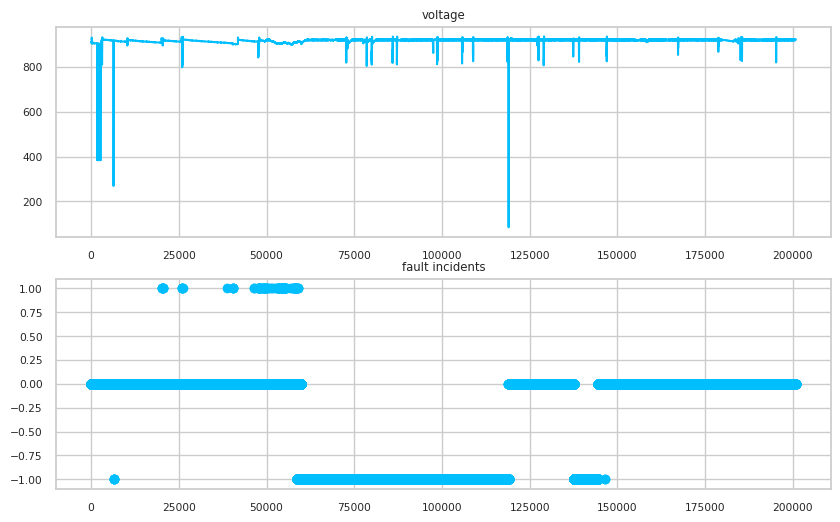

In [5]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

axs[0].plot(voltage_data)
axs[0].set_title("voltage")
axs[1].scatter(range(len(fault_data)), fault_data)
axs[1].set_title("fault incidents")

Train region: 145000-end

Test region: 45000-60000

In [6]:
train_voltage_data = voltage_data[100000:]
test_voltage_data = voltage_data[60000:85000]
val_voltage_data = voltage_data[85000:100000]
fault_voltage_data = voltage_data[0:60000]

Text(0.5, 1.0, 'fault incidents')

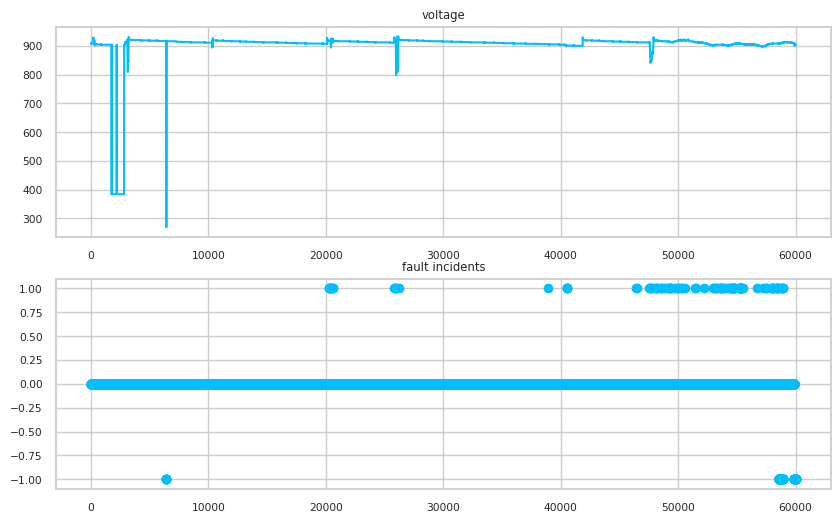

In [7]:
# fault region
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

axs[0].plot(fault_voltage_data)
axs[0].set_title("voltage")
fault_incidents = fault_data[0:60000]
axs[1].scatter(range(len(fault_incidents)), fault_incidents)
axs[1].set_title("fault incidents")

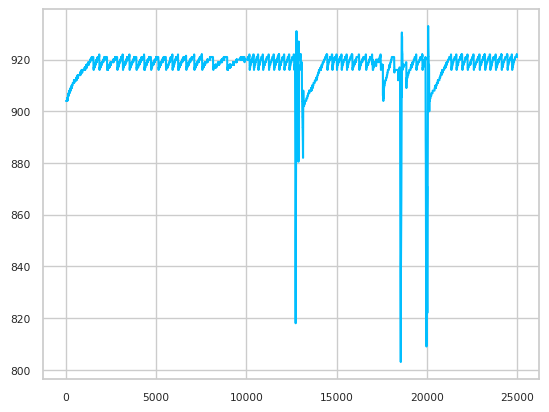

In [8]:
# test region
plt.plot(test_voltage_data)

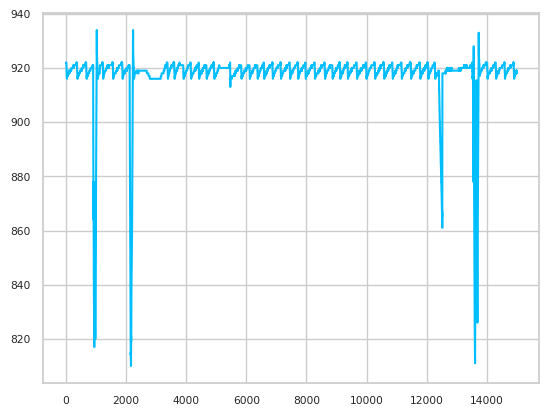

In [9]:
# test region
plt.plot(val_voltage_data)

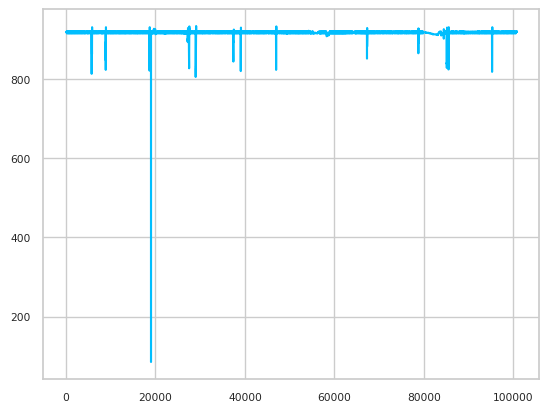

In [10]:

# train region
# plt.plot(voltage_data[145000:])
plt.plot(train_voltage_data)

## Data Processing

In [11]:
train_voltage_data.to_numpy().shape

(100774,)

In [12]:
test_voltage_data.to_numpy().shape

(25000,)

In [13]:
data = train_voltage_data.to_numpy()
segment_size = 100
segments = [ torch.tensor(data[i:i + segment_size]).unsqueeze(1).float() for i in range(0, len(data), segment_size) ]


In [14]:
if (segments[-1].shape[0] != segment_size):
    segments.pop()

In [15]:
torch.stack(segments).shape

torch.Size([1007, 100, 1])

In [16]:
def create_dataset(series, segment_size, mean, stdev):
    # normalize the data
    data = (series.to_numpy() - mean)/stdev
    segments = [ torch.tensor(data[i:i + segment_size]).unsqueeze(1).float() for i in range(0, len(data), segment_size) ]
    # reject the last segment if it doesn't fit the shape
    if (segments[-1].shape[0] != segment_size):
        segments.pop()
    n_seq, seq_len, n_features = torch.stack(segments).shape

    return segments, seq_len, n_features


In [17]:
data = train_voltage_data.to_numpy()
mean = np.mean(data)
stdev = np.std(data)


segment_size = 60
train_dataset, seq_len, n_features = create_dataset(train_voltage_data, segment_size, mean, stdev)
val_dataset, _, _ = create_dataset(val_voltage_data, segment_size, mean, stdev)
test_normal_dataset, _, _ = create_dataset(test_voltage_data, segment_size, mean, stdev)
test_anomaly_dataset, _, _ = create_dataset(fault_voltage_data, segment_size, mean, stdev)

## Encoder Decoder

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [20]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [21]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [22]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

In [22]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [106]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=100
)

Epoch 1: train loss 7.188362143299209 val loss 10.97716400551796
Epoch 2: train loss 7.061609009534848 val loss 10.861721575021743
Epoch 3: train loss 7.050498445725213 val loss 10.759196199297905
Epoch 4: train loss 6.953788480228296 val loss 10.529170639157295
Epoch 5: train loss 6.819667443375704 val loss 10.165040640830993
Epoch 6: train loss 6.738479136036151 val loss 9.992541402816773
Epoch 7: train loss 6.614317140013353 val loss 9.791294813871383
Epoch 8: train loss 6.452131601406606 val loss 9.845977551937104
Epoch 9: train loss 6.408218298855107 val loss 9.518717983603478
Epoch 10: train loss 6.238182526727458 val loss 9.489320818185806
Epoch 11: train loss 6.234057898515033 val loss 9.289050007283688
Epoch 12: train loss 6.202264721316195 val loss 9.33216683781147
Epoch 13: train loss 6.1222286748257755 val loss 9.25562231683731
Epoch 14: train loss 6.28904679132722 val loss 10.131250357687474
Epoch 15: train loss 6.073458283509507 val loss 11.110596370041371
Epoch 16: train

NameError: name 'history' is not defined

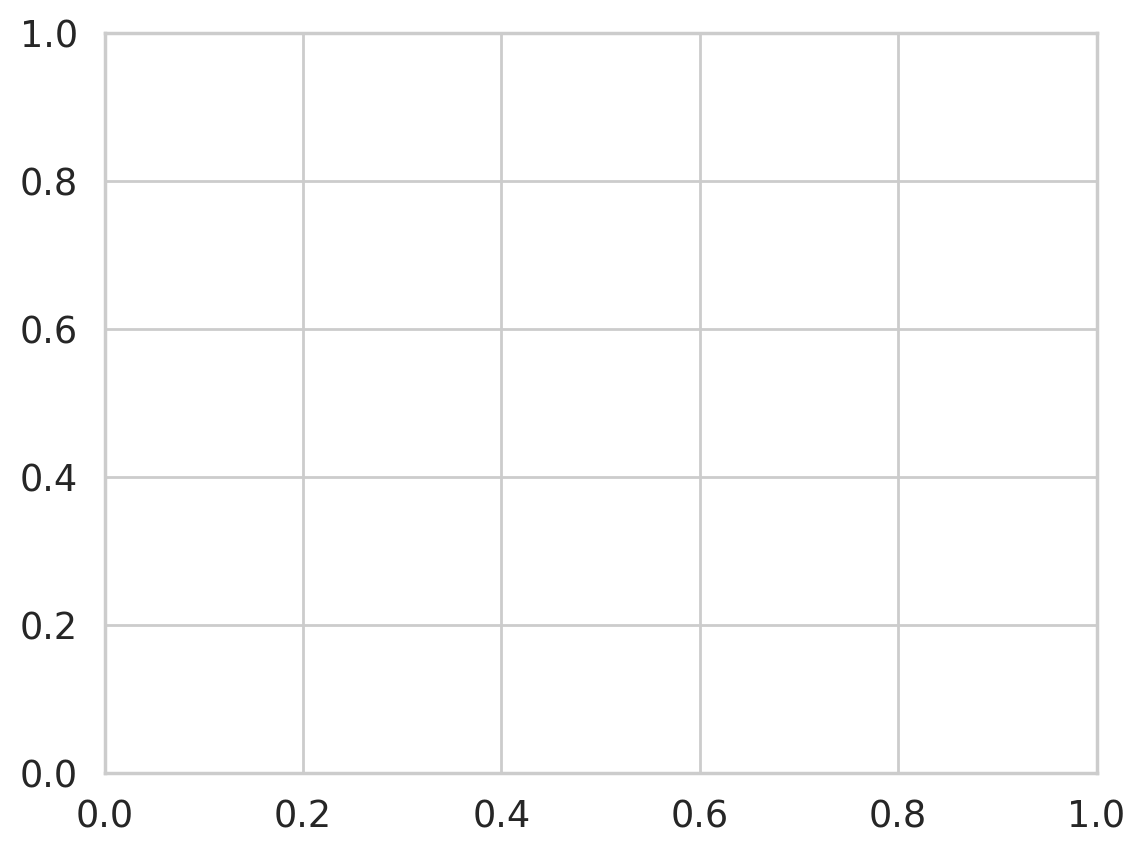

In [23]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Save the model


In [107]:
date = datetime.date.today().strftime('%y-%m-%d')
MODEL_PATH = f'model_save/model_{date}.pth'

torch.save(model, MODEL_PATH)

In [23]:
# reload the model
model = torch.load('model_save/model_23-08-29_1647.pth')
model = model.to(device)

## Check reconstruction error

In [24]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [25]:
_, losses = predict(model, test_normal_dataset)

<Axes: ylabel='Density'>

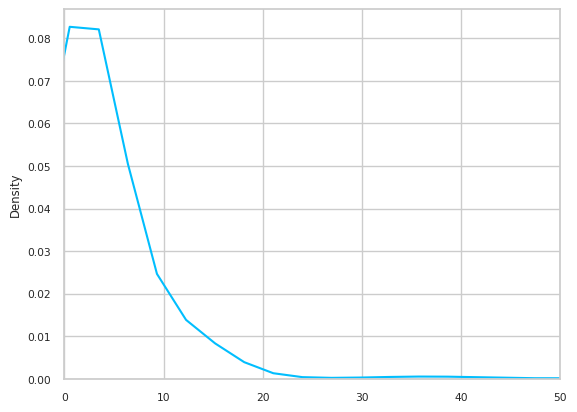

In [26]:
_, losses = predict(model, train_dataset)
plt.xlim(0, 50)
sns.kdeplot(losses)

<Axes: ylabel='Density'>

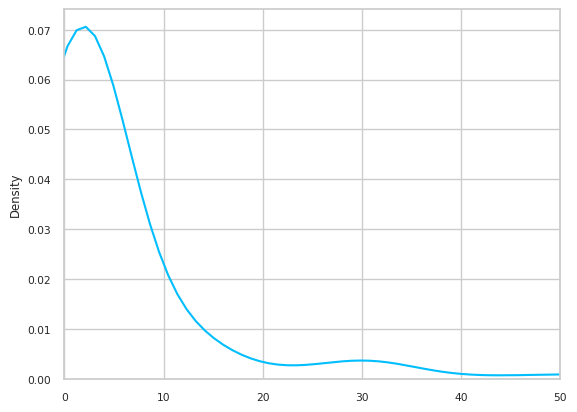

In [27]:
# _, losses = predict(model, train_dataset)
_, losses = predict(model, test_normal_dataset)
plt.xlim(0, 50)
sns.kdeplot(losses)

<Axes: ylabel='Density'>

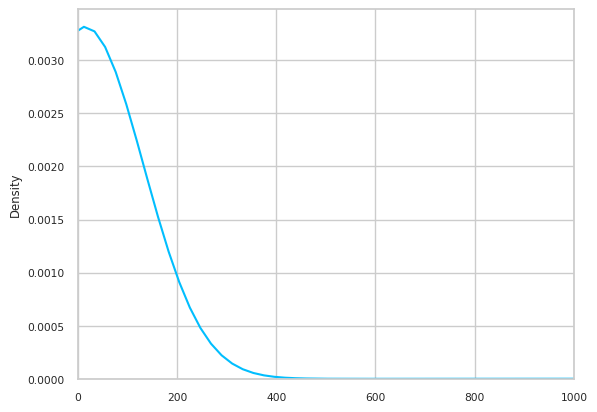

In [28]:
# _, losses = predict(model, train_dataset)
_, losses = predict(model, test_anomaly_dataset)
plt.xlim(0, 1000)
sns.kdeplot(losses)

## Predictions

Compute THRESHOLD with training set data

In [29]:
predictions, losses = predict(model, train_dataset)

In [30]:
loss_array = np.array(losses)

In [31]:
stdev = np.std(loss_array)
mean = np.mean(loss_array)
THRESHOLD = mean + stdev * 1

Check on test_normal_dataset

In [32]:
_, losses = predict(model, test_normal_dataset)
exceed_count = sum(l > THRESHOLD for l in losses)
print(f'number of intervals exceeding 1 std dev loss: {exceed_count}/{len(test_normal_dataset)}')

number of intervals exceeding 1 std dev loss: 33/416


Check on test_anomaly_dataset

In [33]:
_, losses = predict(model, test_anomaly_dataset)
exceed_count = sum(l > THRESHOLD for l in losses)
print(f'number of intervals exceeding 1 std dev loss: {exceed_count}/{len(test_normal_dataset)}')

number of intervals exceeding 1 std dev loss: 333/416


## plot construction error vs original

In [34]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

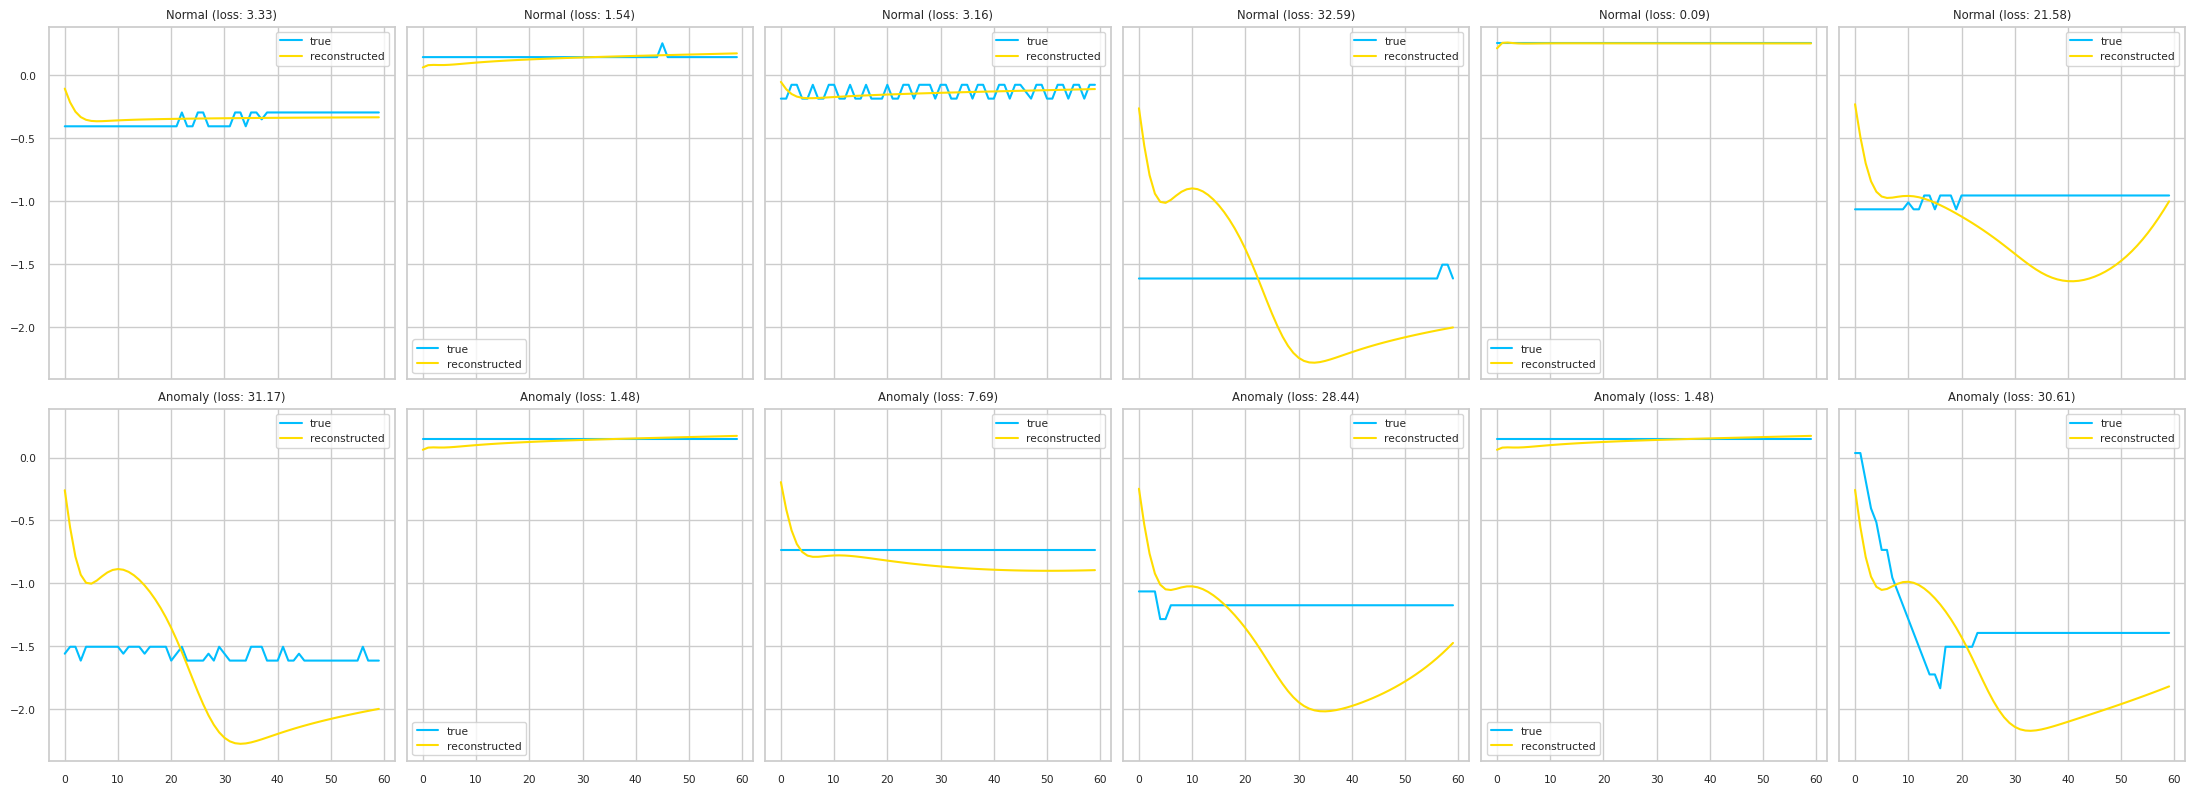

In [35]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8)
)

sample_size = 6
sample_indices = random.sample(range(0,len(test_normal_dataset)), sample_size)

sampled_test_normal_dataset = [test_normal_dataset[i] for i in sample_indices]
sampled_test_anomaly_dataset = [test_anomaly_dataset[i] for i in sample_indices]

for i, data in enumerate(sampled_test_normal_dataset):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(sampled_test_anomaly_dataset):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Assess quality of prediction of flagged intervals

In [36]:
# we want to identify the count of anomalies in each interval in the "test_anomaly_dataset"
# range: 45000:60000
start_point = 0
end_point = 60000
fault_segments = [ fault_data[start_point+seq_len * i:start_point + seq_len * i + seq_len] for i in range(len(test_anomaly_dataset)) ]
# len(test_anomaly_dataset)
anomaly_count_list = [ fault_segments[i].count(1) for i in range(len(fault_segments))]
anomaly_flag_actual = [ count > 0 for count in anomaly_count_list ]

In [37]:
# there are 50 - 100 minute segments where there is an anomaly
sum(np.array(anomaly_count_list) > 0)

69

In [38]:
_, losses = predict(model, test_anomaly_dataset)

In [39]:
anomaly_flag_prediction = [ l > THRESHOLD for l in losses ]

In [40]:
result_mat = confusion_matrix(anomaly_flag_actual, anomaly_flag_prediction)

In [41]:
print(result_mat)

[[642 289]
 [ 25  44]]


In [45]:
tn, fp, fn, tp = result_mat.ravel()

In [48]:
# accuracy of negatives
specificity = tn / (tn + fp)
print(specificity)

# accuracy of positives
sensitivity = tp / (tp + fn)
print(sensitivity)


overall_accuracy = (tn + tp) / (tn + fp + fn + tp)
print(overall_accuracy)

0.6895810955961332
0.6376811594202898
0.686


## plot regions of predicted anomalies

### juxtapose over anomalous region

In [49]:
_, losses = predict(model, test_anomaly_dataset)

In [50]:
anomaly_flag_prediction = [ l > THRESHOLD for l in losses ]

In [51]:
x_segments = []
count = 0
for i in anomaly_flag_prediction:
    count = count + 1
    x_segments.append([count*60, count*60 + 60])
y_segments = [ [0,0] for i in x_segments]

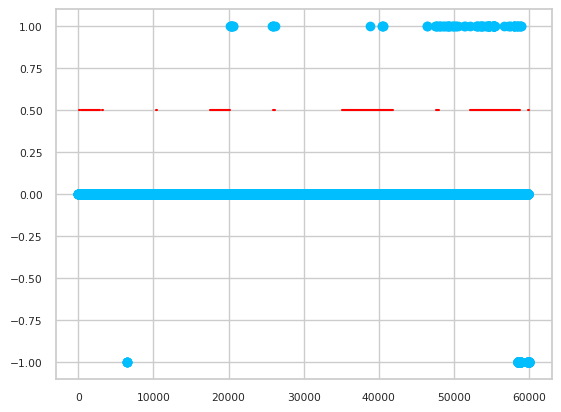

In [52]:
# fault region
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

fig, ax = plt.subplots()
fault_incidents = fault_data[0:60000]
ax.scatter(range(len(fault_incidents)), fault_incidents)
true_color ="green"
false_color = "red"

labels = anomaly_flag_prediction
sequences = x_segments

y_level = 0.5
for i, (sequence, label) in enumerate(zip(sequences, labels)):
    if label:
        ax.plot((sequence[0],sequence[1]), (y_level,y_level), color="red")



### juxtapose over whole dataset

In [53]:
_, losses = predict(model, train_dataset)

In [54]:
anomaly_flag_prediction = [ l > THRESHOLD for l in losses ]
x_segments = []
count = 0
for i in anomaly_flag_prediction:
    count = count + 1
    x_segments.append([count*60, count*60 + 60])
y_segments = [ [0,0] for i in x_segments]

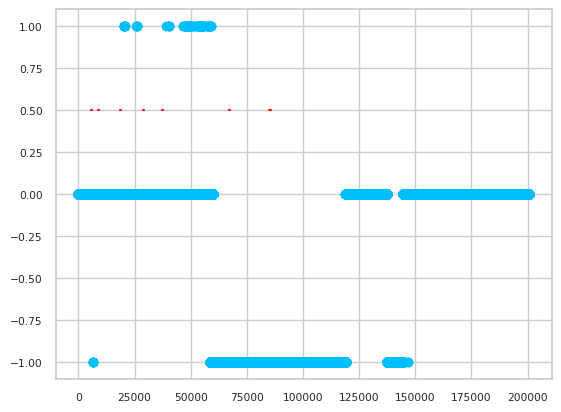

In [55]:
# fault region
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,3 * 2))

fig, ax = plt.subplots()
fault_incidents = fault_data
ax.scatter(range(len(fault_incidents)), fault_incidents)
true_color ="green"
false_color = "red"

labels = anomaly_flag_prediction
sequences = x_segments

y_level = 0.5
for i, (sequence, label) in enumerate(zip(sequences, labels)):
    if label:
        ax.plot((sequence[0],sequence[1]), (y_level,y_level), color="red")

